To-do List:
- Try MCMC sampling (NUTS/HMC)
- simulate noisy circuits
- custom priors

In [69]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import pickle
%matplotlib inline

import torch
from torch.distributions import constraints
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F

import pyro
import pyro.distributions as dist
from pyro.infer import Predictive, SVI, Trace_ELBO
from pyro.optim import Adam, SGD

In [70]:
assert pyro.__version__.startswith('1.8.6')
pyro.distributions.enable_validation(False)
pyro.set_rng_seed(0)
# Enable smoke test - run the notebook cells on CI.
smoke_test = True

In [155]:
name = "mixed2"
filename = name+"_statistics"
path = "data/"+filename

probabilities = []
with open(path, "r") as f:
    lines = f.read().splitlines()
for line in lines:
    outcome, freq = line.split(" ")
    number = int(outcome)
    probabilities.append(float(freq))
options = range(len(probabilities))
print(probabilities)
n_samples = 10000
data = np.random.choice(options, n_samples, p=probabilities)

[0.03275316126456784, 0.07433745245314644, 0.08560266556890885, 0.03105468650411968, 0.07800488512225356, 0.0445530843938049, 0.10778157015101043, 0.03035647449368503, 0.06520108267103343, 0.07528250384039785, 0.04098800351185825, 0.06826535114822851, 0.06921112217159749, 0.030688856777883022, 0.07784206060410001, 0.08807703932340669]


In [208]:
class QuantumStateTomography(nn.Module):
    def __init__(self, n=3, alpha = 0.1, K=1, POVM=None, sigma =1):
        super().__init__()
        #define hyperparameters
        self.N = 2**n        # size of system (2^num qubits)
        self.alpha = alpha   # sparsity of the density matrix
        self.K = K           # rank of the density matrix
        if POVM is not None:
            self.POVM = torch.from_numpy(POVM).type(torch.complex64) # measurement set used
        else:
            self.POVM = None
        self.sigma = sigma   # variance of the complex vectors

    def model(self, data):
        # draw a probability distribution over K pure states
        theta = pyro.sample("theta", dist.Dirichlet(torch.ones(self.K) * self.alpha))
    
        # generate K pure states
        with pyro.plate("pure states", self.K):
            real_part = pyro.sample("real_part", dist.MultivariateNormal(torch.zeros(self.N), torch.eye(self.N)))
            imag_part = pyro.sample("imag_part", dist.MultivariateNormal(torch.zeros(self.N), torch.eye(self.N)))
            complex_vector = torch.complex(real_part, imag_part)
            norm_vector = complex_vector / torch.norm(complex_vector, dim=-1, keepdim=True)
        norm_vector = torch.transpose(norm_vector,0,1)
        
        # compute the density matrix (rho)
        if self.POVM is None:
            # standard basis measurements
            squared = torch.conj(norm_vector) * norm_vector
            probabilities = (squared @ theta.type(torch.complex64))
            with pyro.plate("data", len(data)):
                return pyro.sample("obs", dist.Categorical(probabilities.real), obs=data)
        else:
            # print('povm', self.POVM.shape)
            # print('norm_vector', norm_vector.shape, norm_vector)
            inner_prods = torch.matmul(torch.conj(self.POVM), norm_vector)
            squared = torch.conj(inner_prods) * inner_prods
            probabilities = (squared @ theta.type(torch.complex64))
            with pyro.plate("data", len(data)):
                return pyro.sample("obs", dist.Categorical(probabilities.real), obs=data)

    
    def guide(self, data):
        constrained_vector = pyro.param("constrained_vector", torch.ones(self.K) / self.K, constraint=constraints.simplex)
        theta = pyro.sample("theta", dist.Delta(constrained_vector).to_event(1))
    
        with pyro.plate("pure states", self.K):
            real_mean = pyro.param("real_mean", torch.randn(self.K, self.N))
            imag_mean = pyro.param("imag_mean", torch.randn(self.K, self.N))
            sigma_real = pyro.param("sigma_real", 0.1 * torch.ones(self.K, self.N), constraint=constraints.positive)
            sigma_imag = pyro.param("sigma_imag", 0.1 * torch.ones(self.K, self.N), constraint=constraints.positive)
            
            cov_matrix_real = torch.zeros(self.K, self.N, self.N)
            cov_matrix_imag = torch.zeros(self.K, self.N, self.N)
            for i in range(self.K):
                cov_matrix_real[i] = torch.diag(sigma_real[i])
                cov_matrix_imag[i] = torch.diag(sigma_imag[i])
    
            real_part = pyro.sample("real_part", dist.MultivariateNormal(real_mean, covariance_matrix=cov_matrix_real))
            imag_part = pyro.sample("imag_part", dist.MultivariateNormal(imag_mean, covariance_matrix=cov_matrix_imag))

In [209]:
def train(svi, train_loader, use_cuda=False):
    # initialize loss accumulator
    epoch_loss = 0.
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for x in train_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # do ELBO gradient and accumulate loss
        epoch_loss += svi.step(x)

    # return epoch loss
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train
def evaluate(svi, test_loader, use_cuda=False):
    # initialize loss accumulator
    test_loss = 0.
    # compute the loss over the entire test set
    for x in test_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # compute ELBO estimate and accumulate loss
        test_loss += svi.evaluate_loss(x)
    normalizer_test = len(test_loader.dataset)
    total_epoch_loss_test = test_loss / normalizer_test
    return total_epoch_loss_test
def setup_data_loaders(data, batch_size=128, use_cuda=False):
    root = './data'
    download = True
    random.shuffle(data)
    n = len(data)
    cutoff = int(0.9*n)
    train_set = torch.Tensor(data[:cutoff])
    test_set = torch.Tensor(data[cutoff:])

    kwargs = {'num_workers': 4, 'pin_memory': use_cuda}
    train_loader = torch.utils.data.DataLoader(dataset=train_set,
        batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(dataset=test_set,
        batch_size=batch_size, shuffle=False, **kwargs)
    return train_loader, test_loader

In [210]:
# Run options
LEARNING_RATE = 1.0e-3
USE_CUDA = False
smoke_test = False

# Run only for a single iteration for testing
NUM_EPOCHS = 2 if smoke_test else 100
TEST_FREQUENCY = 5

In [211]:
with open("data/mixed2_POVM", "rb") as f:
    POVM = pickle.load(f)

print(torch.from_numpy(POVM).type(torch.complex64))

tensor([[ 0.1231-0.2208j,  0.1181+0.1642j,  0.1609+0.1174j, -0.1591+0.1775j],
        [-0.0573+0.1948j, -0.2354-0.0540j, -0.0624+0.1806j, -0.0577+0.2542j],
        [ 0.1704+0.2070j, -0.0403+0.2388j,  0.1599-0.1913j, -0.0175+0.2116j],
        [-0.0563-0.2419j,  0.1137-0.2191j,  0.0952-0.1599j,  0.0290+0.2537j],
        [ 0.0887+0.2208j,  0.2305+0.0441j,  0.2179+0.0615j,  0.0776+0.1929j],
        [ 0.2874+0.0514j, -0.1990+0.1889j, -0.0533-0.3434j, -0.2639+0.0334j],
        [-0.2815-0.0517j,  0.2520-0.1549j,  0.2460+0.2238j, -0.2355+0.0430j],
        [ 0.1682+0.1557j, -0.1910-0.0666j, -0.0766+0.1662j, -0.2366-0.0477j],
        [-0.0819-0.1829j, -0.1728+0.2218j, -0.1980-0.1962j, -0.1491-0.1736j],
        [-0.2065+0.0837j, -0.1943+0.1537j, -0.1848+0.1160j, -0.1704+0.1607j],
        [ 0.2122+0.1373j,  0.2835+0.0664j,  0.1907+0.1131j, -0.0919-0.2848j],
        [ 0.1828+0.0305j, -0.2468-0.0171j,  0.1626+0.1552j,  0.2615+0.0526j],
        [-0.2241-0.1903j, -0.2895+0.0183j,  0.2768-0.0414j, -0.0

In [224]:
train_loader, test_loader = setup_data_loaders(data,batch_size=128, use_cuda=USE_CUDA)
n_qubits = 2
n_states = 2

# clear param store
pyro.clear_param_store()

qst = QuantumStateTomography(n=n_qubits, K=n_states, POVM=POVM)
optimizer = Adam({"lr": LEARNING_RATE})
autoguide = pyro.infer.autoguide.AutoNormal(qst.model)
svi = SVI(qst.model, qst.guide, optimizer, loss=Trace_ELBO())

train_elbo = []
test_elbo = []
# training loop
pbar = tqdm(range(NUM_EPOCHS))
for epoch in pbar:
    total_epoch_loss_train = train(svi, train_loader, use_cuda=USE_CUDA)
    train_elbo.append(-total_epoch_loss_train)
    pbar.set_description("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))

    if epoch % TEST_FREQUENCY == 0:
        # report test diagnostics
        total_epoch_loss_test = evaluate(svi, test_loader, use_cuda=USE_CUDA)
        test_elbo.append(-total_epoch_loss_test)
        pbar.set_description("[epoch %03d] average test loss: %.4f" % (epoch, total_epoch_loss_test))

[epoch 099]  average training loss: 2.8354: 100%|█| 100/100 [02:35<00:00,  1.56s


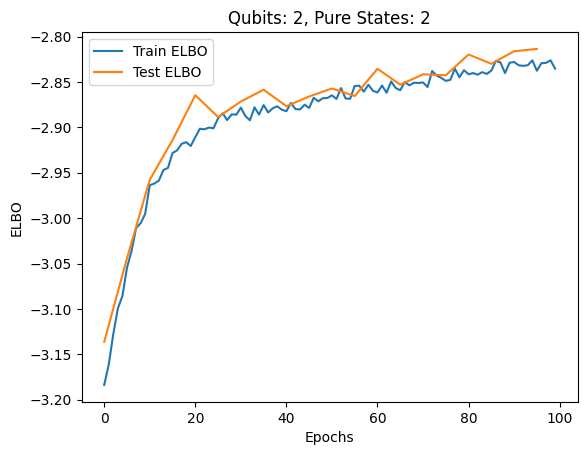

In [225]:
epochs = np.arange(len(train_elbo))
plt.plot(epochs, train_elbo, label='Train ELBO')
epochs = np.arange(len(test_elbo))
plt.plot(epochs*TEST_FREQUENCY, test_elbo, label='Test ELBO')
plt.xlabel('Epochs')
plt.ylabel('ELBO')
plt.legend()
plt.title(f"Qubits: {n_qubits}, Pure States: {n_states}")
plt.show()

In [226]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())
# data_ = torch.tensor(data)
# predictive_svi = Predictive(qst.model, guide=guide, num_samples=500)(data_)
# for k, v in predictive_svi.items():
#     print(f"{k}: {tuple(v.shape)}")

constrained_vector [0.9160418  0.08395823]
real_mean [[-0.5266276  -0.01340488  0.06997499 -0.16716717]
 [ 0.29783085  0.06442977  0.22397627 -0.17241311]]
imag_mean [[-2.7936907   0.00338355 -0.08937788 -0.8740235 ]
 [-0.11955225 -0.28878656  0.3246035  -0.01355341]]
sigma_real [[0.4392812  0.05554779 0.07419173 0.08907422]
 [0.6392348  0.72434527 0.7801248  0.5974656 ]]
sigma_imag [[0.23027343 0.05884126 0.0472052  0.0539431 ]
 [0.7607755  0.789639   0.7793265  0.7859437 ]]


In [227]:
from scipy.linalg import sqrtm
def trace_dist(a, b):
    k = a-b
    M = np.matmul(k.conj().T,k)
    B = sqrtm(M)
    return np.trace(B).real/2

def fidelity(a,b):
    k = sqrtm(a)
    M = k @ b @ k
    return (np.trace(sqrtm(M)).real)**2

In [233]:
real_part = pyro.param('real_mean').data
imag_part = pyro.param('imag_mean').data
theta = pyro.param('constrained_vector').data.numpy()
vecs = F.normalize(torch.complex(real_part, imag_part), p=2, dim=1).numpy()
approx_DM = (np.conj(vecs.T) @ np.diag(theta) @vecs)

with open("data/mixed2_density", "rb") as file:
    rho = pickle.load(file)
true_DM = rho

print(true_DM)
print(np.round(approx_DM,3))

print('Trace Distance:',trace_dist(approx_DM, true_DM))
print('Fidelity:', fidelity(approx_DM, true_DM))

approx_prob = np.round(np.real(np.diag(approx_DM)),3)
real_prob = np.round(np.real(np.diag(true_DM)),3)

print('approximate probabilities:',approx_prob)
print('real probabilities:', real_prob)

#print(np.round(approx_prob - real_prob,3))

[[0.875+0.j 0.   +0.j 0.   +0.j 0.125+0.j]
 [0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j]
 [0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j]
 [0.125+0.j 0.   +0.j 0.   +0.j 0.125+0.j]]
[[ 0.856-0.j     0.012-0.022j  0.028+0.053j  0.25 -0.006j]
 [ 0.012+0.022j  0.02 -0.j    -0.018+0.019j -0.002-0.01j ]
 [ 0.028-0.053j -0.018-0.019j  0.036+0.j    -0.003+0.004j]
 [ 0.25 +0.006j -0.002+0.01j  -0.003-0.004j  0.088+0.j   ]]
Trace Distance: 0.16678683308660963
Fidelity: 0.8929366200443107
approximate probabilities: [0.856 0.02  0.036 0.088]
real probabilities: [0.875 0.    0.    0.125]
